In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

In [21]:
# Read the TSV file and add column headers
file_path = '/data/synth-GDN001/refs/two_genomes_aln'
file_path = '/data/synth-GDN001/refs/top5aln'
columns = ['query', 'target', 'fident', 'alnlen', 'mismatch', 'gapopen', 'qstart', 'qend', 'tstart', 'tend', 'evalue', 'bits']
df = pd.read_csv(file_path, sep='\t', header=None, names=columns)

## Interspecies Misassemblies

In [ ]:

# Ensure alnlen column is of type int
df['alnlen'] = df['alnlen'].astype(int)

# Extract species from the 'query' and 'target' columns
df['query_species'] = df['query']
df['target_species'] = df['target']

# Define the top 5 species and their corresponding GCF IDs
species_ids = {
    'Actinomyces_dentalis': 'GCF_000429225.1',
    'Actinomyces_sp_900323545': '3300008059_1',
    'Desulfobulbus_oralis': 'GCA_905373745.1',
    'Hornefia_minuta': 'GCA_003433295.1',
    'Flexilinea_sp': 'GCA_001717545.1'
}

def get_category(row):
    for species, gcf_id in species_ids.items():
        if gcf_id in row['query_species'] and gcf_id in row['target_species']:
            if row['qstart'] != row['tstart'] or row['qend'] != row['tend']:
                return f'Within {species}'
            else:
                return 'Other'  # Exclude exact self-hits
        elif gcf_id in row['query_species'] or gcf_id in row['target_species']:
            other_gcf_ids = list(species_ids.values())
            other_gcf_ids.remove(gcf_id)
            for other_gcf_id in other_gcf_ids:
                if other_gcf_id in row['query_species'] or other_gcf_id in row['target_species']:
                    return f'Between {species} and {list(species_ids.keys())[list(species_ids.values()).index(other_gcf_id)]}'
    return 'Other'

In [29]:
def getAlns(df, maxVal):
    # Ensure 'alnlen' column is of type int
    df['alnlen'] = df['alnlen'].astype(int)
    
    # Define the top 5 species and their corresponding GCF IDs
    species_ids = {
        'Actinomyces_dentalis': 'GCF_000429225.1',
        'Actinomyces_sp_900323545': '3300008059_1',
        'Desulfobulbus_oralis': 'GCA_905373745.1',
        'Hornefia_minuta': 'GCA_003433295.1',
        'Flexilinea_sp': 'GCA_001717545.1'
    }
    
    def get_category(row):
        for species, gcf_id in species_ids.items():
            if gcf_id in row['query'] and gcf_id in row['target']:
                if row['qstart'] != row['tstart'] or row['qend'] != row['tend']:
                    return f'Within {species}'
                else:
                    return 'Other'  # Exclude exact self-hits
            elif gcf_id in row['query'] or gcf_id in row['target']:
                for other_gcf_id in set(species_ids.values()) - {gcf_id}:
                    if other_gcf_id in row['query'] or other_gcf_id in row['target']:
                        other_species = list(species_ids.keys())[list(species_ids.values()).index(other_gcf_id)]
                        return f'Between {species} and {other_species}'
        return 'Other'
    
    # Apply the function to create a new column for the category
    df['category'] = df.apply(get_category, axis=1)
    
    # Filter out the 'Other' category if not needed
    df_filtered = df[df['category'] != 'Other']

    # Plot the density plot
    plt.figure(figsize=(14, 5))

    # Manually plot each category to ensure the legend works
    categories = df_filtered['category'].unique()
    for category in categories:
        subset = df_filtered[df_filtered['category'] == category]
        sns.kdeplot(data=subset, x='alnlen', fill=True, common_norm=False, label=category)
    
    plt.xticks(np.arange(0, 2001, 100))
    plt.xlabel('Alignment Length (bp)')
    plt.ylabel('Density')
    plt.title('Highly Similar Alignments Within Species Genome Per Length')
    
    # Adjust x-axis limits to match the provided maxVal
    plt.xlim(0, maxVal)
    
    # Add a legend and adjust layout
    plt.legend(title='Category')
    plt.tight_layout()
    plt.savefig('misassmbly_investigate/miasm_intraspecies/intraspecies_align_GDN.png', dpi=300, bbox_inches="tight")
    plt.show()


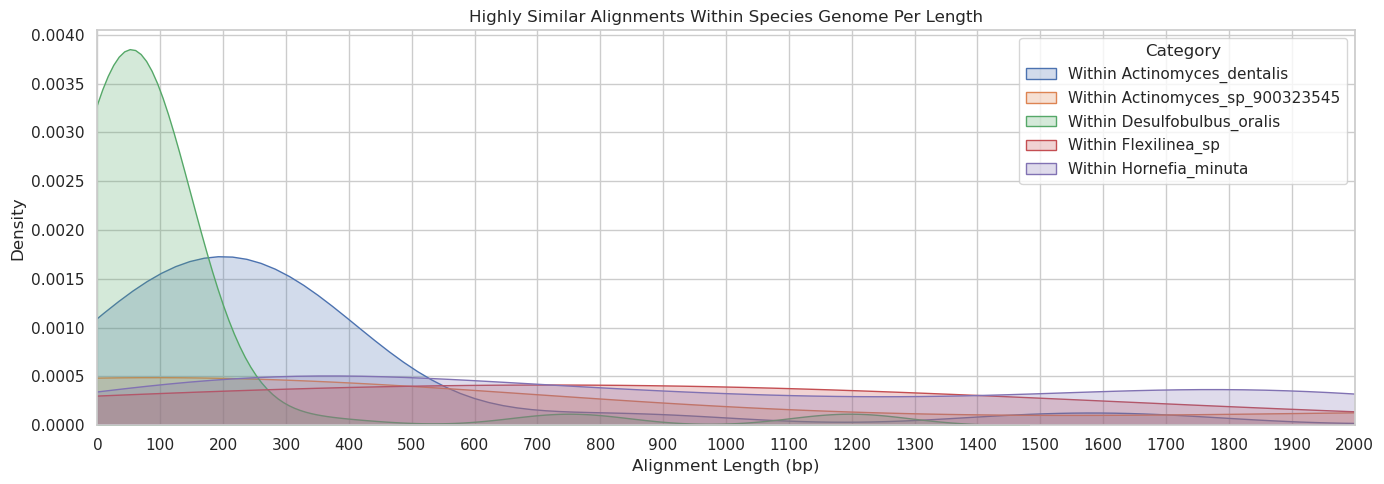

In [30]:
getAlns(df, 2000)

In [ ]:
hits_count

## Intraspecies Misassemblies

In [17]:
#List of species
species = [
    "Actinomyces_dentalis----GCF_000429225.1",
    "Actinomyces_sp900323545----3300008059_1",
    "Desulfobulbus_oralis----GCA_905373745.1",
    "Flexilinea_sp001717545----GCA_001717545.1",
    "Pauljensenia_cardiffensis----GCA_905373095.1"
]

def read_kmers(file_path):
    kmers = set()
    with open(file_path, 'r') as file:
        for line in file:
            kmer = line.strip().split()[0]
            kmers.add(kmer)
    return kmers

def find_shared_and_unique_kmers(path, species1, species2, kmer_size):
    kmer_file1 = f"{path}/kmercounts/{species1}/kmer_{kmer_size}.txt"
    kmer_file2 = f"{path}/kmercounts/{species2}/kmer_{kmer_size}.txt"

    if os.path.isfile(kmer_file1) and os.path.isfile(kmer_file2):
        kmers1 = read_kmers(kmer_file1)
        kmers2 = read_kmers(kmer_file2)

        shared_kmers = kmers1.intersection(kmers2)
        total_unique_kmers = kmers1.union(kmers2)
        
        shared_kmer_count = len(shared_kmers)
        total_unique_kmer_count = len(total_unique_kmers)
        
        if total_unique_kmer_count == 0:
            fraction_shared = 0
        else:
            fraction_shared = shared_kmer_count / total_unique_kmer_count
        
        return shared_kmer_count, total_unique_kmer_count, fraction_shared
    else:
        print(f"One or both k-mer files missing for {species1} and {species2} with k-mer size {kmer_size}")
        return 0, 0, 0.0





In [20]:
mypath = "/vol/cloud/louis/data/synth-GDN001/refs/kmers"
results = []

for i in range(len(species)):
    for j in range(i + 1, len(species)):
        species1 = species[i]
        species2 = species[j]
        
        for kmer_size in range(50, 102, 2):
            shared_kmer_count, total_unique_kmer_count, fraction_shared = find_shared_and_unique_kmers(mypath, species1, species2, kmer_size)
            results.append({
                'Species1': species1,
                'Species2': species2,
                'Kmer_Size': kmer_size,
                'Shared_Kmers': shared_kmer_count,
                'Total_Unique_Kmers': total_unique_kmer_count,
                'Fraction_Shared': fraction_shared
            })

df = pd.DataFrame(results)
df.to_csv('shared_kmers_fractions.csv', index=False)
print("Results saved to 'shared_kmers_fractions.csv'")


Results saved to 'shared_kmers_fractions.csv'


In [ ]:
df

In [ ]:
# Create a unique identifier for each pair of species
df = pd.read_csv('misassmbly_investigate/shared_kmers_fractions.csv')

df['Pair'] = df['Species1'] + ' vs\n' + df['Species2']

# Set up the plotting style
sns.set(style="whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(10, 6))

# Plotting
sns.lineplot(x='Kmer_Size', y='Fraction_Shared', hue='Pair', data=df, marker='o')

# Customize the plot
plt.title('Fraction of Shared k-mers per Pair of Species and k-mer Size')
plt.xlabel('k-mer Size')
plt.ylabel('Fraction of Shared k-mers')
plt.legend(title='Species Pairs', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.savefig('misassmbly_investigate/misasm_interspecies/interspecies_kmers_GDN.png', dpi=300, bbox_inches="tight")
plt.show()
